# Customer Lifetime Value: Modeling Customer Profile for Underwriting Optimization
### The goal of this project is to create a model that predicts the customer lifetime values (CLV) of a given customer profile for auto insurance underwriting. 

## Load the data set and import libraries

In [1]:
## import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

#set plotting style
sns.set_style('whitegrid')

In [2]:
clv_df = pd.read_csv(
    'https://raw.githubusercontent.com/brisamh/modeling_clv/refs/heads/bhalviatti/data/clean_clv_data.csv')

In [3]:
clv_df.head()

,customer,state,customer_lifetime_value,customer_response_to_offer,coverage,education,policy_expiration_date,employment_status,gender,income,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,2011-01-31,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


## Model 1) Linear Regression: All Predictors Used

#### Before fitting the model we will drop data we do not need and perform one-hot encoding of categorical variables

In [4]:
clv_df = clv_df.drop(columns = ['customer', 'policy_expiration_date'])

We will convert the categorical variables to dummies dropping the first variable in each category.

In [5]:
clv_df_model_1 = clv_df
clv_df_model_1 = pd.get_dummies(clv_df_model_1, drop_first=True)

Find all columns in  clv_df that have the Boolean data type and convert them to 0 and 1.

In [6]:
bool_cols = clv_df_model_1.select_dtypes(include='bool').columns
clv_df_model_1[bool_cols] = clv_df_model_1[bool_cols].astype(int)

Create OLS model using all predictors available

In [7]:
X_1 = clv_df_model_1.drop(columns = 'customer_lifetime_value') 
y_1 = clv_df_model_1['customer_lifetime_value'] 

In [8]:
X_1 = sm.add_constant(X_1)
model_1 = sm.OLS(y_1, X_1).fit()
print(model_1.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.169
Model:                                 OLS   Adj. R-squared:                  0.165
Method:                      Least Squares   F-statistic:                     38.60
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):          6.92e-323
Time:                             15:18:19   Log-Likelihood:                -92812.
No. Observations:                     9134   AIC:                         1.857e+05
Df Residuals:                         9085   BIC:                         1.861e+05
Df Model:                               48                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [9]:
print(model_1.pvalues[model_1.pvalues < 0.05].drop('const', errors='ignore'))

monthly_premium_auto              4.187587e-12
number_of_open_complaints         2.686336e-04
number_of_policies                3.759583e-02
education_High School or Below    2.491937e-02
employment_status_Employed        4.818648e-02
marital_status_Single             2.972820e-02
policy_Corporate L2               1.662197e-02
renew_offer_type_Offer2           5.389205e-09
renew_offer_type_Offer3           7.542192e-03
renew_offer_type_Offer4           2.989086e-07
dtype: float64


### Model 1 Interpretation:
* We have included all the variables in our model to begin with, but the R-Squared is only 0.169
* Of 49 variables, only 10 were statistically significant (p-value < 0.05)
* We did not include any interaction terms, despite seeing a 'stripe' effect in our data that indicates variable interactions

## Model 2) Linear Regression: Removing CLV Outliers

As noted in our EDA, there is a lot of variablity in CLV specifically for customers with two policies. We will explore dropping CLV when it is outside the bounds of the 75th percentile of the two policy group, then re-modeling the data without these outliers:

In [10]:
clv_df[clv_df['number_of_policies'] == 2].describe()

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
count,2294.000000,2294.000000,2294.000000,2294.000000,2294.000000,2294.000000,2294.0,2294.000000
mean,15723.177937,37001.553182,93.261552,15.044900,47.812554,0.364429,2.0,433.610653
std,9300.866249,30051.712074,33.426835,9.996519,27.948144,0.858842,0.0,282.363856
min,5409.955926,0.000000,61.000000,0.000000,0.000000,0.000000,2.0,1.489470
25%,8642.421929,0.000000,68.250000,6.000000,23.000000,0.000000,2.0,276.103498
50%,12876.687620,33551.000000,85.000000,14.000000,48.000000,0.000000,2.0,393.600000
75%,19916.955327,61108.000000,109.000000,23.000000,71.000000,0.000000,2.0,547.031224
max,83325.381190,99875.000000,295.000000,35.000000,99.000000,5.000000,2.0,2552.343856


We see above that 75% = 19916.955327 for customers with two policies. Returning to the full dataset, we will drop all records where the CLV exceeds this amount and re-model the data similar to how we performed model 1:

In [11]:
model_2 = clv_df_model_1[clv_df_model_1['customer_lifetime_value'] <= 19916]

In [12]:
X_2 = model_2.drop(columns = 'customer_lifetime_value')
y_2 = model_2['customer_lifetime_value'] 

In [13]:
X_2 = sm.add_constant(X_2)
model_2 = sm.OLS(y_2, X_2).fit()
print(model_2.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.247
Model:                                 OLS   Adj. R-squared:                  0.243
Method:                      Least Squares   F-statistic:                     58.09
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                             15:18:20   Log-Likelihood:                -81290.
No. Observations:                     8555   AIC:                         1.627e+05
Df Residuals:                         8506   BIC:                         1.630e+05
Df Model:                               48                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [14]:
print(model_2.pvalues[model_2.pvalues < 0.05].drop('const', errors='ignore'))

monthly_premium_auto         2.358791e-14
number_of_open_complaints    7.639587e-05
number_of_policies           3.645461e-84
coverage_Premium             4.259707e-02
education_College            4.922172e-02
education_Master             2.954872e-02
marital_status_Single        9.462825e-03
policy_Corporate L2          2.816731e-02
policy_Corporate L3          2.086841e-02
policy_Personal L3           4.276820e-02
renew_offer_type_Offer2      3.923400e-13
renew_offer_type_Offer3      3.827024e-04
renew_offer_type_Offer4      7.756365e-11
vehicle_class_SUV            5.807066e-03
vehicle_size_Small           3.317256e-02
dtype: float64


### Model 2 Interpretation
* The model has an R-squared of 0.247, which while moderately better than model 1, does not explain enough variation in our data to be meaningful.
* There are 5 more statistically significant predictors than seen with model 1.
* The model also suggests that there are strong multicollinearity problems that make it difficult to determine the effect of each preditor on the CLV.

## Model 3) Linear Regression: Including Interaction Terms

From the EDA, we know that vast amount of variation, skew, and spread comes from having two policies. We will create a dummy variable to account for this. Then, we re-run the full model (Model 1), but include the interaction between policy premium and a Y/N flag for two policies:

In [15]:
X_3 = clv_df_model_1.drop(columns = 'customer_lifetime_value') 
y_3 = clv_df_model_1['customer_lifetime_value'] 

X_3['two_policies'] = (X_3['number_of_policies'] == 2).astype(int)
X_3['premium_policy_intrxn'] = X_3['two_policies'] * X_3['monthly_premium_auto']

X_3 = sm.add_constant(X_3)
model_3 = sm.OLS(y_3, X_3).fit()
print(model_3.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.666
Model:                                 OLS   Adj. R-squared:                  0.664
Method:                      Least Squares   F-statistic:                     361.6
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                             15:18:20   Log-Likelihood:                -88657.
No. Observations:                     9134   AIC:                         1.774e+05
Df Residuals:                         9083   BIC:                         1.778e+05
Df Model:                               50                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

#### Can we achieve similiar results with a reduced model, that only includes the interaction term?

In this model, the goal is to predict the CLV where monthly premium auto and policy count being 2 as interacting terms. 

In [16]:
clv_df_model_3a = clv_df_model_1
clv_df_model_3a['two_policies'] = (clv_df_model_3a['number_of_policies'] == 2).astype(int)

In [17]:
model_3a = smf.ols(formula='customer_lifetime_value ~ (monthly_premium_auto) * (two_policies)'
                             , data=clv_df_model_3a).fit()

In [18]:
print(model_3a.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.627
Model:                                 OLS   Adj. R-squared:                  0.627
Method:                      Least Squares   F-statistic:                     5108.
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                             15:18:20   Log-Likelihood:                -89160.
No. Observations:                     9134   AIC:                         1.783e+05
Df Residuals:                         9130   BIC:                         1.784e+05
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

### Plot the residuals

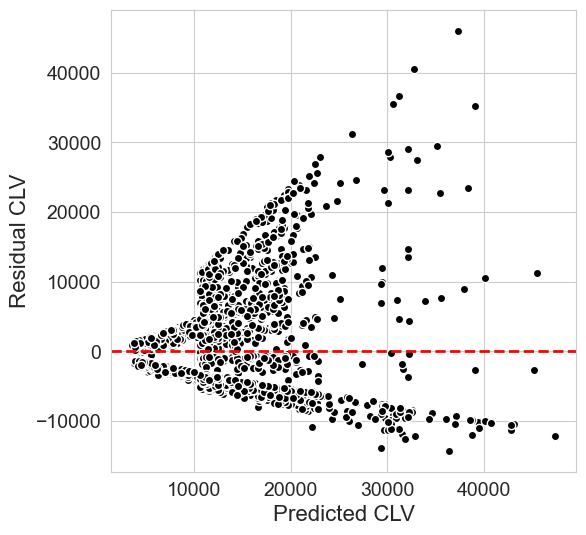

In [19]:
y_hat = model_3a.predict()

plt.figure(figsize=(6,6))

plt.plot(y_hat, model_3a.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted CLV', fontsize=16)
plt.ylabel('Residual CLV', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

### Model 3 Interpretation:
* Addressing the interaction between policy count and Monthly Premium provided a significant lift on explanatory power: R-squared went from 0.169 to 0.666 simply by adding an interaction term
* This interaction term alone, as a single variate linear regression, has an R-Squared of 0.627
* The residuals however, are not quite random-- something is still failing to fully explain the variation
* Capturing the two policy group is a key to successfully modeling CLV

## Model 4) Individual Linear Regression Models per Policy Count

First step will be creating 9 sepearte dataframes for each policy count


In [20]:
clv_df_1pol = clv_df.loc[clv_df['number_of_policies'] == 1] 
clv_df_2pol = clv_df.loc[clv_df['number_of_policies'] == 2] 
clv_df_3pol = clv_df.loc[clv_df['number_of_policies'] == 3] 
clv_df_4pol = clv_df.loc[clv_df['number_of_policies'] == 4] 
clv_df_5pol = clv_df.loc[clv_df['number_of_policies'] == 5] 
clv_df_6pol = clv_df.loc[clv_df['number_of_policies'] == 6] 
clv_df_7pol = clv_df.loc[clv_df['number_of_policies'] == 7] 
clv_df_8pol = clv_df.loc[clv_df['number_of_policies'] == 8] 
clv_df_9pol = clv_df.loc[clv_df['number_of_policies'] == 9]

Below we will create a model for each number of policies a customer has, and print the results for number of policies. 

We will only use the coefficients that are statistically significant, with a p-value less than or equal to 0.05:

In [21]:
clv_df_1pol = pd.get_dummies(clv_df_1pol, drop_first=True)
bool_cols = clv_df_1pol.select_dtypes(include='bool').columns
clv_df_1pol[bool_cols] = clv_df_1pol[bool_cols].astype(int)

X_1pol = clv_df_1pol.drop(columns = ['customer_lifetime_value','number_of_policies']) 
y_1pol = clv_df_1pol['customer_lifetime_value']

X_1pol = sm.add_constant(X_1pol)
model_1pol = sm.OLS(y_1pol, X_1pol).fit()

significant_predictors = [var for var, p in model_1pol.pvalues.items()
                          if (p < 0.05 and var != 'const')]

model_1pol = sm.OLS(y_1pol, sm.add_constant(X_1pol[significant_predictors])).fit()

print(model_1pol.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.996
Model:                                 OLS   Adj. R-squared:                  0.996
Method:                      Least Squares   F-statistic:                 2.881e+04
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                             15:18:20   Log-Likelihood:                -19329.
No. Observations:                     3251   AIC:                         3.871e+04
Df Residuals:                         3224   BIC:                         3.888e+04
Df Model:                               26                                         
Covariance Type:                 nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [22]:
clv_df_2pol= pd.get_dummies(clv_df_2pol, drop_first=True)
bool_cols = clv_df_2pol.select_dtypes(include='bool').columns
clv_df_2pol[bool_cols] = clv_df_2pol[bool_cols].astype(int)
X_2pol = clv_df_2pol.drop(columns = ['customer_lifetime_value','number_of_policies']) 
y_2pol = clv_df_2pol['customer_lifetime_value'] 

X_2pol = sm.add_constant(X_2pol)
model_2pol = sm.OLS(y_2pol, X_2pol).fit()

significant_predictors = [var for var, p in model_2pol.pvalues.items()
                          if (p < 0.05 and var != 'const')]

model_2pol = sm.OLS(y_2pol, sm.add_constant(X_2pol[significant_predictors])).fit()

print(model_2pol.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.326
Model:                                 OLS   Adj. R-squared:                  0.325
Method:                      Least Squares   F-statistic:                     221.5
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):          3.93e-193
Time:                             15:18:21   Log-Likelihood:                -23764.
No. Observations:                     2294   AIC:                         4.754e+04
Df Residuals:                         2288   BIC:                         4.757e+04
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [23]:
clv_df_3pol= pd.get_dummies(clv_df_3pol, drop_first=True)
bool_cols = clv_df_3pol.select_dtypes(include='bool').columns
clv_df_3pol[bool_cols] = clv_df_3pol[bool_cols].astype(int)
X_3pol = clv_df_3pol.drop(columns = ['customer_lifetime_value','number_of_policies'])
y_3pol = clv_df_3pol['customer_lifetime_value'] 

X_3pol = sm.add_constant(X_3pol)
model_3pol = sm.OLS(y_3pol, X_3pol).fit()

significant_predictors = [var for var, p in model_3pol.pvalues.items()
                          if (p < 0.05 and var != 'const')]

model_3pol = sm.OLS(y_3pol, sm.add_constant(X_3pol[significant_predictors])).fit()

print(model_3pol.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.995
Model:                                 OLS   Adj. R-squared:                  0.995
Method:                      Least Squares   F-statistic:                 1.042e+04
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                             15:18:21   Log-Likelihood:                -7654.5
No. Observations:                     1168   AIC:                         1.535e+04
Df Residuals:                         1146   BIC:                         1.546e+04
Df Model:                               21                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

#### Repeat for remaining policy counts, uncomment the final print line to see results

In [24]:
clv_df_4pol= pd.get_dummies(clv_df_4pol, drop_first=True)
bool_cols = clv_df_4pol.select_dtypes(include='bool').columns
clv_df_4pol[bool_cols] = clv_df_4pol[bool_cols].astype(int)
X_4pol = clv_df_4pol.drop(columns = ['customer_lifetime_value','number_of_policies'])
y_4pol = clv_df_4pol['customer_lifetime_value'] 

X_4pol = sm.add_constant(X_4pol)
model_4pol = sm.OLS(y_4pol, X_4pol).fit()

significant_predictors = [var for var, p in model_4pol.pvalues.items()
                          if (p < 0.05 and var != 'const')]

model_4pol = sm.OLS(y_4pol, sm.add_constant(X_4pol[significant_predictors])).fit()

print(model_4pol.summary()) 


                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.995
Model:                                 OLS   Adj. R-squared:                  0.994
Method:                      Least Squares   F-statistic:                     5540.
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                             15:18:21   Log-Likelihood:                -2701.4
No. Observations:                      409   AIC:                             5431.
Df Residuals:                          395   BIC:                             5487.
Df Model:                               13                                         
Covariance Type:                 nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [25]:
clv_df_5pol= pd.get_dummies(clv_df_5pol, drop_first=True)
bool_cols = clv_df_5pol.select_dtypes(include='bool').columns
clv_df_5pol[bool_cols] = clv_df_5pol[bool_cols].astype(int)
X_5pol = clv_df_5pol.drop(columns = ['customer_lifetime_value','number_of_policies'])
y_5pol = clv_df_5pol['customer_lifetime_value'] 

X_5pol = sm.add_constant(X_5pol)
model_5pol = sm.OLS(y_5pol, X_5pol).fit()

significant_predictors = [var for var, p in model_5pol.pvalues.items()
                          if (p < 0.05 and var != 'const')]

model_5pol = sm.OLS(y_5pol, sm.add_constant(X_5pol[significant_predictors])).fit()

print(model_5pol.summary())


                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.995
Model:                                 OLS   Adj. R-squared:                  0.995
Method:                      Least Squares   F-statistic:                     4897.
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                             15:18:21   Log-Likelihood:                -2738.4
No. Observations:                      407   AIC:                             5509.
Df Residuals:                          391   BIC:                             5573.
Df Model:                               15                                         
Covariance Type:                 nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [26]:
clv_df_6pol= pd.get_dummies(clv_df_6pol, drop_first=True)
bool_cols = clv_df_6pol.select_dtypes(include='bool').columns
clv_df_6pol[bool_cols] = clv_df_6pol[bool_cols].astype(int)
X_6pol = clv_df_6pol.drop(columns = ['customer_lifetime_value','number_of_policies'])
y_6pol = clv_df_6pol['customer_lifetime_value'] 

X_6pol = sm.add_constant(X_6pol)
model_6pol = sm.OLS(y_6pol, X_6pol).fit()

significant_predictors = [var for var, p in model_6pol.pvalues.items()
                          if (p < 0.05 and var != 'const')]

model_6pol = sm.OLS(y_6pol, sm.add_constant(X_6pol[significant_predictors])).fit()

print(model_6pol.summary())


                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.994
Model:                                 OLS   Adj. R-squared:                  0.994
Method:                      Least Squares   F-statistic:                     4286.
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                             15:18:21   Log-Likelihood:                -2454.7
No. Observations:                      372   AIC:                             4941.
Df Residuals:                          356   BIC:                             5004.
Df Model:                               15                                         
Covariance Type:                 nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [27]:
clv_df_7pol= pd.get_dummies(clv_df_7pol, drop_first=True)
bool_cols = clv_df_7pol.select_dtypes(include='bool').columns
clv_df_7pol[bool_cols] = clv_df_7pol[bool_cols].astype(int)
X_7pol = clv_df_7pol.drop(columns = ['customer_lifetime_value','number_of_policies']) 
y_7pol = clv_df_7pol['customer_lifetime_value'] 

X_7pol = sm.add_constant(X_7pol)
model_7pol = sm.OLS(y_7pol, X_7pol).fit()


significant_predictors = [var for var, p in model_7pol.pvalues.items()
                          if (p < 0.05 and var != 'const')]

model_7pol = sm.OLS(y_7pol, sm.add_constant(X_7pol[significant_predictors])).fit()

print(model_7pol.summary())


                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.993
Model:                                 OLS   Adj. R-squared:                  0.992
Method:                      Least Squares   F-statistic:                     3571.
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                             15:18:21   Log-Likelihood:                -3016.9
No. Observations:                      433   AIC:                             6068.
Df Residuals:                          416   BIC:                             6137.
Df Model:                               16                                         
Covariance Type:                 nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [28]:
clv_df_8pol= pd.get_dummies(clv_df_8pol, drop_first=True)
bool_cols = clv_df_8pol.select_dtypes(include='bool').columns
clv_df_8pol[bool_cols] = clv_df_8pol[bool_cols].astype(int)
X_8pol = clv_df_8pol.drop(columns = ['customer_lifetime_value','number_of_policies']) 
y_8pol = clv_df_8pol['customer_lifetime_value'] 

X_8pol = sm.add_constant(X_8pol)
model_8pol = sm.OLS(y_8pol, X_8pol).fit()

significant_predictors = [var for var, p in model_8pol.pvalues.items()
                          if (p < 0.05 and var != 'const')]

model_8pol = sm.OLS(y_8pol, sm.add_constant(X_8pol[significant_predictors])).fit()

print(model_8pol.summary())


                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.995
Model:                                 OLS   Adj. R-squared:                  0.995
Method:                      Least Squares   F-statistic:                     5981.
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                             15:18:21   Log-Likelihood:                -2547.8
No. Observations:                      384   AIC:                             5122.
Df Residuals:                          371   BIC:                             5173.
Df Model:                               12                                         
Covariance Type:                 nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [29]:
clv_df_9pol= pd.get_dummies(clv_df_9pol, drop_first=True)
bool_cols = clv_df_9pol.select_dtypes(include='bool').columns
clv_df_9pol[bool_cols] = clv_df_9pol[bool_cols].astype(int)
X_9pol = clv_df_9pol.drop(columns = ['customer_lifetime_value','number_of_policies']) 
y_9pol = clv_df_9pol['customer_lifetime_value'] 

X_9pol = sm.add_constant(X_9pol)
model_9pol = sm.OLS(y_9pol, X_9pol).fit()

significant_predictors = [var for var, p in model_9pol.pvalues.items()
                          if (p < 0.05 and var != 'const')]

model_9pol = sm.OLS(y_9pol, sm.add_constant(X_9pol[significant_predictors])).fit()
print(model_9pol.summary())


                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.996
Model:                                 OLS   Adj. R-squared:                  0.996
Method:                      Least Squares   F-statistic:                     5440.
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                             15:18:21   Log-Likelihood:                -2698.8
No. Observations:                      416   AIC:                             5440.
Df Residuals:                          395   BIC:                             5524.
Df Model:                               20                                         
Covariance Type:                 nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

### Model 4 Interpretation:
* We see incredible results for each individual policy count, except for when a customer has 2 policies
* Using linear regression we can produce an R-Squared of 0.99 for customers with 1 or 3 policies
* The same linear regression model for customers with 2 policies has an R-Squared of 0.340
* The same is true for remaining policy counts, results for policies 4-8 were hidden to avoid redundancy

## Model 5) Create Two Separate Linear Regression Models: Excluding 2 Policies and Only Two Policies

Model 5a will be for all customers excluding those with two policies

In [30]:
clv_df_exclude_2 = clv_df.loc[clv_df['number_of_policies'] != 2]

Model 5b will be for customers with exactly two policies

In [31]:
clv_df_is_2 = clv_df.loc[clv_df['number_of_policies'] == 2]

First step will be to one-hot encode categorical variables into a numerical format then handle boolean conversions, and defining the predictor (X) and response (y) variables for the customer lifetime value prediction. 

Following that, we will add an intercept to the predictors and subsequently fit an OLS model. 

Finally, print out the summary of the fitted model.

In [32]:
clv_df_exclude_2= pd.get_dummies(clv_df_exclude_2, drop_first=True)
bool_cols = clv_df_exclude_2.select_dtypes(include='bool').columns
clv_df_exclude_2[bool_cols] = clv_df_exclude_2[bool_cols].astype(int)
X_5a = clv_df_exclude_2.drop(columns = 'customer_lifetime_value') 
y_5a = clv_df_exclude_2['customer_lifetime_value'] 


X_5a = sm.add_constant(X_5a)

model_5a = sm.OLS(y_5a, X_5a).fit()

print(model_5a.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.796
Model:                                 OLS   Adj. R-squared:                  0.795
Method:                      Least Squares   F-statistic:                     553.4
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                             15:18:22   Log-Likelihood:                -58336.
No. Observations:                     6840   AIC:                         1.168e+05
Df Residuals:                         6791   BIC:                         1.171e+05
Df Model:                               48                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

Similarly, we will create a model for customers with exactly 2 policies.

In [33]:
clv_df_is_2= pd.get_dummies(clv_df_is_2, drop_first=True)
bool_cols = clv_df_is_2.select_dtypes(include='bool').columns
clv_df_is_2[bool_cols] = clv_df_is_2[bool_cols].astype(int)
X_5b = clv_df_is_2.drop(columns = 'customer_lifetime_value') 
y_5b = clv_df_is_2['customer_lifetime_value']


X_5b = sm.add_constant(X_5b)

model_5b = sm.OLS(y_5b, X_5b).fit()

print(model_5b.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.340
Model:                                 OLS   Adj. R-squared:                  0.326
Method:                      Least Squares   F-statistic:                     24.58
Date:                     Thu, 11 Dec 2025   Prob (F-statistic):          1.14e-166
Time:                             15:18:22   Log-Likelihood:                -23741.
No. Observations:                     2294   AIC:                         4.758e+04
Df Residuals:                         2246   BIC:                         4.785e+04
Df Model:                               47                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

We will consolidate the p-values for both models to identify the sifnificant predictor variables for the models. 

In [34]:
model5_pvals = pd.DataFrame({
    'Model5a_pval': model_5a.pvalues.round(3),
    'Model5b_pval': model_5b.pvalues.round(3)
})
significant_both = model5_pvals[(model5_pvals['Model5a_pval'] < 0.05) | 
                            (model5_pvals['Model5b_pval'] < 0.05)]

print(significant_both)

                                Model5a_pval  Model5b_pval
const                                  0.000           NaN
customer_response_to_offer_Yes         0.000         0.954
education_High School or Below         0.006         0.152
education_Master                       0.000         0.259
employment_status_Employed             0.461         0.020
employment_status_Retired              0.013         0.318
employment_status_Unemployed           0.015         0.297
gender_M                               0.047         0.002
income                                 0.000         0.516
location_code_Suburban                 0.010         0.555
location_code_Urban                    0.005         0.808
marital_status_Single                  0.008         0.409
monthly_premium_auto                   0.000         0.000
months_since_last_claim                0.973         0.016
number_of_open_complaints              0.000         0.108
number_of_policies                     0.000         0.8

### Model 5 Interpretation:
* Excluding the customers with two policies (Model 5a) we see an R-Squared of 0.796
* The R-Squared for customers with exactly two policies (Model 5b) has an R-Squared of 0.340
* This indicates that our linear regression model works very well when a customer does not have two policies

## Model 6) Random Forest

Using the full dataset, but with a Random Forest model:

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [36]:
clv_df_model_6 = clv_df_model_1.drop(columns = ['two_policies'])

In [37]:
X_rf = clv_df_model_6.drop(columns = 'customer_lifetime_value') 
y_rf = clv_df_model_6['customer_lifetime_value'] 

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=1)

In [39]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [41]:
y_pred = rf_model.predict(X_test)

In [42]:
r2 = r2_score(y_test, y_pred)
print(f"R² Score of train set: {r2}")

R² Score of train set: 0.6904633113615202


### Random Forest without 2 policies

In [43]:
rf_no_2_policy = clv_df_model_1[clv_df_model_1['two_policies'] == 0 ]

In [44]:
X_hat = rf_no_2_policy.drop(columns = 'customer_lifetime_value') 
y2 = rf_no_2_policy['customer_lifetime_value'] 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_hat, y2, test_size=0.2, random_state=1)

In [45]:
rf_model2 = RandomForestRegressor()
rf_model2.fit(X_train2, y_train2)

RandomForestRegressor()

In [46]:
y_pred2 = rf_model2.predict(X_test2)
r2 = r2_score(y_test2, y_pred2)
print(f"R² Score of train set: {r2}")

R² Score of train set: 0.9960556895520198


### Model 6 Interpretation:
* For the best possible results, in one model, we recommend the Random Forest model be applied so long as the customer in question does not have exactly two policies
* For the most explainability, we recommend using the linear regression model that corresponds to the number of policies a customer has (Model 4)
* Significant additional research is needed to identify the root cause of the instability of modeling CLV for customers with exactly two policies